In [153]:
%%capture
%pip install -r requirements.txt

# Global Covid Cases per Week

In [154]:
from utilities import * 

## Process and Import Data

In [155]:
# Use Public Online data 

url = "https://catalog.ourworldindata.org/garden/covid/latest/compact/compact.csv"
df = pd.read_csv(url)

In [156]:
df['date'] = pd.to_datetime(df['date'])
df = df[df['date'] < '2023-06-01']
df['week_start'] = df['date'] - pd.to_timedelta(df['date'].dt.weekday, unit='D')
df.drop(columns = 'date', inplace = True)

weekly_df = df.copy()
weekly_df = df.groupby(['week_start', 'country']).sum().reset_index()

In [157]:
## check for missing values
weekly_df.isna().sum().sum()

0

In [158]:
# Manually Create Variant Data 
weekly_df['variant'] = 'pre_variant'

# Define the variant start dates
delta_start = pd.to_datetime('2021-05-01')
omicron_start = pd.to_datetime('2021-11-01')

# Define the three-month end dates
delta_end = delta_start + pd.DateOffset(months=3)
omicron_end = omicron_start + pd.DateOffset(months=3)

weekly_df.loc[(weekly_df['week_start'] >= delta_start) & (weekly_df['week_start'] < delta_end), 'variant'] = 'delta'
weekly_df.loc[(weekly_df['week_start'] >= omicron_start) & (weekly_df['week_start'] < omicron_end), 'variant'] = 'omicron'

## one hot encode for modeling down the line 
weekly_df = pd.get_dummies(weekly_df, columns=['variant'])
weekly_df['variant_pre_variant'] = weekly_df['variant_pre_variant'].astype(int)
weekly_df['variant_delta'] = weekly_df['variant_delta'].astype(int)
weekly_df['variant_omicron'] = weekly_df['variant_omicron'].astype(int)


In [159]:
weekly_df.head()

,week_start,country,total_cases,new_cases,new_cases_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths,new_deaths,...,life_expectancy,gdp_per_capita,extreme_poverty,diabetes_prevalence,handwashing_facilities,hospital_beds_per_thousand,human_development_index,variant_delta,variant_omicron,variant_pre_variant
0,2019-12-30,Afghanistan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,309.9120,7581.3665,0.000000,54.5,241.073475,1.95,2.310,0,0,1
1,2019-12-30,Africa,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,123.3218,0.0000,0.000000,0.0,0.000000,0.00,0.000,0,0,1
2,2019-12-30,Albania,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,382.3130,77460.3350,0.106387,51.0,0.000000,14.45,3.945,0,0,1
3,2019-12-30,Algeria,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,381.8835,55991.1650,2.277338,35.5,424.020500,9.50,3.725,0,0,1
4,2019-12-30,American Samoa,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,145.0796,0.0000,0.000000,40.6,0.000000,0.00,0.000,0,0,1


## EDA 

<Axes: xlabel='week_start', ylabel='new_cases'>

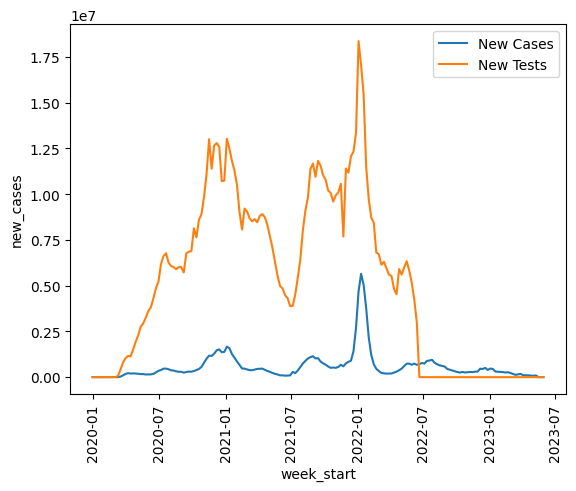

In [177]:
plt.xticks(rotation=90) 
sns.lineplot(x='week_start', y='new_cases', data = weekly_df[weekly_df['country'] == 'United States'], label= 'New Cases')
sns.lineplot(x='week_start', y='new_tests', data = weekly_df[weekly_df['country'] == 'United States'], label= 'New Tests')

<Axes: xlabel='week_start', ylabel='new_cases'>

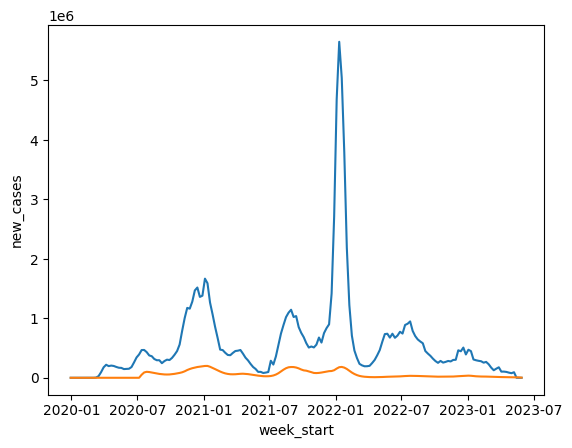

In [176]:
sns.lineplot(x='week_start', y='new_cases', data = weekly_df[weekly_df['country'] == 'United States'])
sns.lineplot(x='week_start', y='icu_patients', data = weekly_df[weekly_df['country'] == 'United States'])

## Proof of Concept Model: US Cases per Week 

In [115]:
## PREP DATA FOR MODELING

selected_cols = [
    'week_start',
    'new_cases',
    'new_tests',
    'variant_delta',
    'variant_omicron', 
    'variant_pre_variant',
    # 'new_deaths',
    # 'new_vaccinations',
    'icu_patients'
]

In [116]:
us_df = weekly_df[weekly_df['country'] == 'United States'].sort_values('week_start', ascending=True).reset_index(drop=True)

In [117]:
us_input = us_df[selected_cols].rename(columns={'week_start':'ds', 'new_cases':'y'})

In [118]:
us_input.head()

,ds,y,new_tests,variant_delta,variant_omicron,variant_pre_variant,icu_patients
0,2019-12-30,0.0,0.0,0,0,1,0.0
1,2020-01-06,0.0,0.0,0,0,1,0.0
2,2020-01-13,0.0,0.0,0,0,1,0.0
3,2020-01-20,7.0,0.0,0,0,1,0.0
4,2020-01-27,2.0,0.0,0,0,1,0.0


In [119]:
## CREATE LAGS 
us_input['new_tests_lag_1'] = df['new_tests'].shift(1)  # Lag by 1 week
us_input['new_tests_lag_2'] = df['new_tests'].shift(2)  # Lag by 2 weeks

us_input['icu_lag_1'] = df['icu_patients'].shift(1)  # Lag by 1 week
us_input['icu_lag_2'] = df['icu_patients'].shift(2)  # Lag by 2 weeks

In [120]:
us_input = us_input.fillna(0)
us_input.head()

,ds,y,new_tests,variant_delta,variant_omicron,variant_pre_variant,icu_patients,new_tests_lag_1,new_tests_lag_2,icu_lag_1,icu_lag_2
0,2019-12-30,0.0,0.0,0,0,1,0.0,0.0,0.0,0.0,0.0
1,2020-01-06,0.0,0.0,0,0,1,0.0,0.0,0.0,0.0,0.0
2,2020-01-13,0.0,0.0,0,0,1,0.0,0.0,0.0,0.0,0.0
3,2020-01-20,7.0,0.0,0,0,1,0.0,0.0,0.0,0.0,0.0
4,2020-01-27,2.0,0.0,0,0,1,0.0,0.0,0.0,0.0,0.0


In [124]:
us_input[us_input['ds']].ds.unique()

<DatetimeArray>
['2019-12-30 00:00:00', '2020-01-06 00:00:00', '2020-01-13 00:00:00',
 '2020-01-20 00:00:00', '2020-01-27 00:00:00', '2020-02-03 00:00:00',
 '2020-02-10 00:00:00', '2020-02-17 00:00:00', '2020-02-24 00:00:00',
 '2020-03-02 00:00:00',
 ...
 '2023-03-27 00:00:00', '2023-04-03 00:00:00', '2023-04-10 00:00:00',
 '2023-04-17 00:00:00', '2023-04-24 00:00:00', '2023-05-01 00:00:00',
 '2023-05-08 00:00:00', '2023-05-15 00:00:00', '2023-05-22 00:00:00',
 '2023-05-29 00:00:00']
Length: 179, dtype: datetime64[ns]

In [121]:
## SPLIT DATA 
training_data = us_input[us_input['ds'] <= '2023-04-01'].reset_index(drop=True)
validation_data = us_input[us_input['ds'] > '2023-04-01'].reset_index(drop=True)

In [133]:
## CREATE MODEL 

holiday_df = pd.DataFrame.from_dict(holidays.country_holidays('US', years= range(2020,2024)), orient='index').reset_index() \
    .rename({'index':'ds', 0:'holiday'}, axis='columns')

change_points = ['2021-11-15', '2022-01-10']
model = Prophet(holidays= holiday_df,
                changepoints = change_points,
    yearly_seasonality= True,
    weekly_seasonality = False,
    daily_seasonality=False)


# add regressor
model.add_regressor('new_tests')
model.add_regressor('new_tests_lag_1')
model.add_regressor('new_tests_lag_2')
model.add_regressor('icu_patients')
model.add_regressor('icu_lag_1')
model.add_regressor('icu_lag_2')
model.add_regressor('variant_pre_variant')
model.add_regressor('variant_omicron')
model.add_regressor('variant_delta')

model.fit(training_data)

12:01:36 - cmdstanpy - INFO - Chain [1] start processing
12:01:36 - cmdstanpy - INFO - Chain [1] done processing
12:01:36 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:01:36 - cmdstanpy - INFO - Chain [1] start processing
12:01:36 - cmdstanpy - INFO - Chain [1] done processing


Training MAPE: inf %


<Axes: xlabel='ds', ylabel='y'>

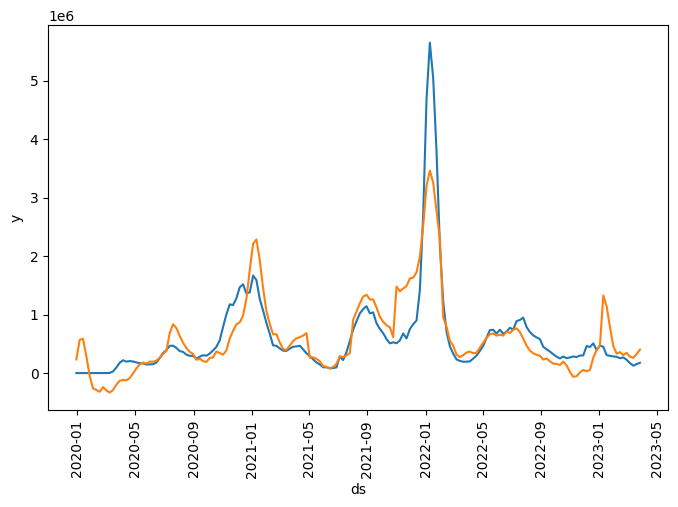

In [134]:
## CREATE PREDCITONS AND GET MODEL PEROFORMANCE 
fig, ax = plt.subplots(figsize=(8, 5)) 
train_predict = model.predict(training_data)
plt.xticks(rotation=90)

mape = calculate_mape(training_data['y'], train_predict['yhat'])
print('Training MAPE:', mape, '%')
sns.lineplot(x='ds', y='y', data=training_data)
sns.lineplot(x='ds', y='yhat', data=train_predict)

Performance Metrics
------------------------
Model MAPE: inf %


<Axes: xlabel='ds', ylabel='y'>

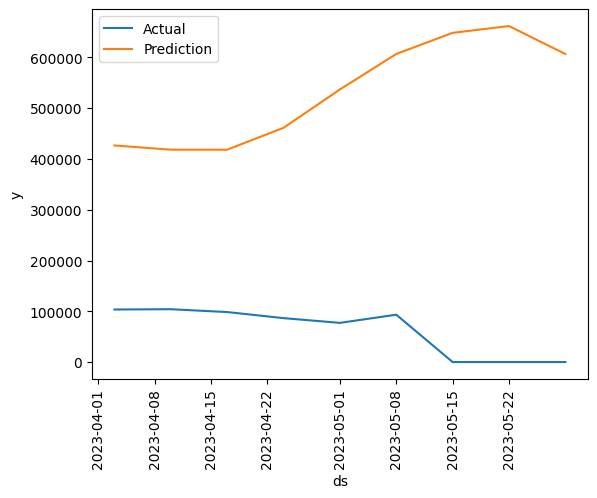

In [135]:
validation_predict = model.predict(validation_data)
model_mape = calculate_mape(validation_data['y'], validation_predict['yhat'])

print('Performance Metrics')
print('------------------------')
print('Model MAPE:', model_mape, '%')

## Benchmark Metric 
validation_data['benchmark'] = np.mean(training_data['y'])
plt.xticks(rotation=90)
sns.lineplot(x='ds', y='y', data=validation_data, label= 'Actual')
sns.lineplot(x='ds', y='yhat', data=validation_predict, label='Prediction')